In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [173]:
data=pd.read_csv('winequality-red.csv')

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [175]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [176]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

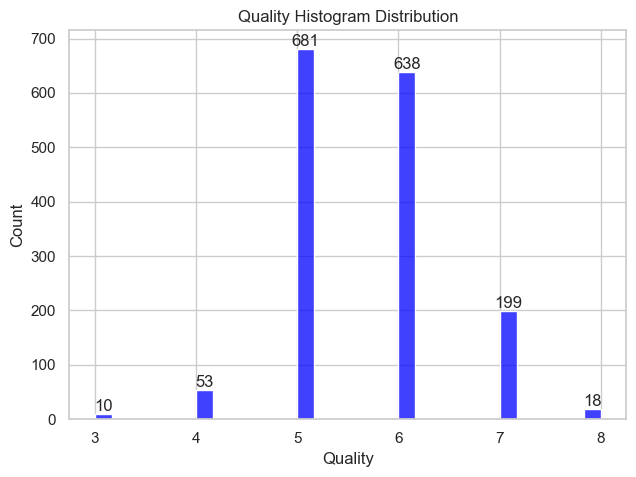

In [177]:
ax = sns.histplot(x=data['quality'], color='blue')
labels = [str(v) if v else '' for v in ax.containers[0].datavalues]
ax.bar_label(ax.containers[0], labels=labels)
plt.xlabel('Quality')
plt.title('Quality Histogram Distribution')
plt.show()

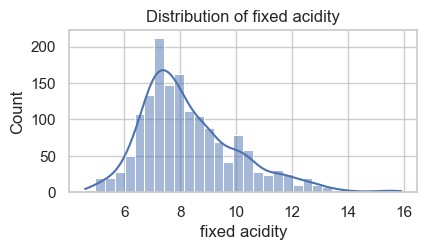

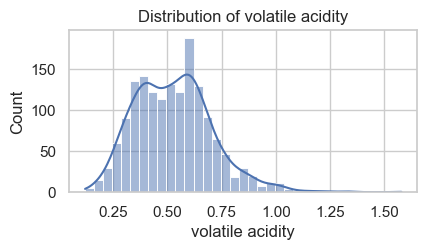

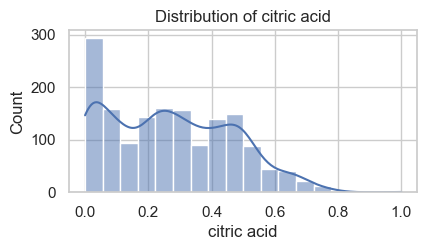

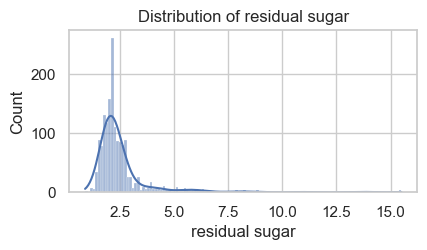

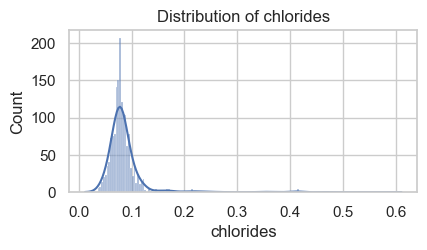

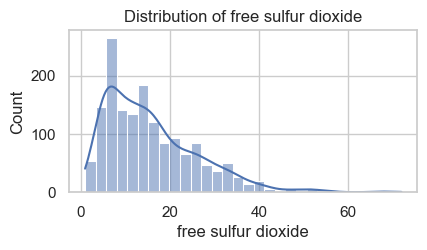

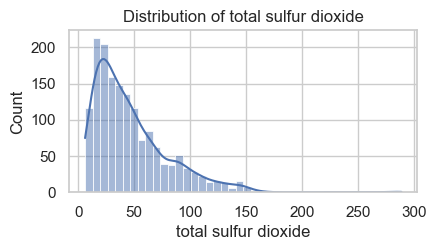

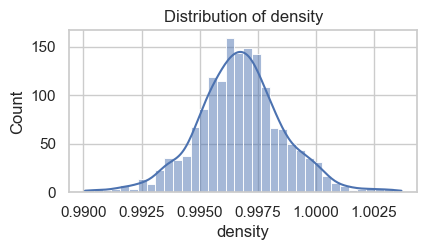

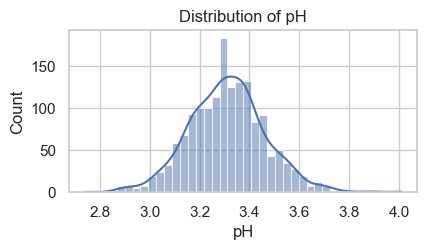

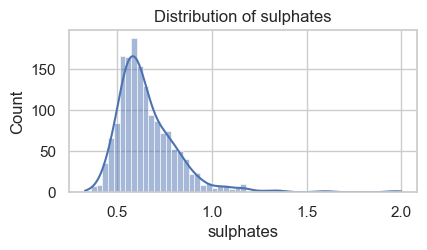

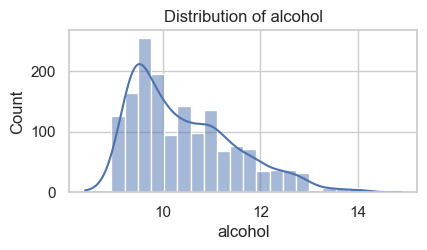

In [178]:
sns.set(style="whitegrid")
for column in data.columns[:-1]:
    plt.figure(figsize=(4,2))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

Text(0.5, 0.98, 'Boxplot Distribution of All Collumns')

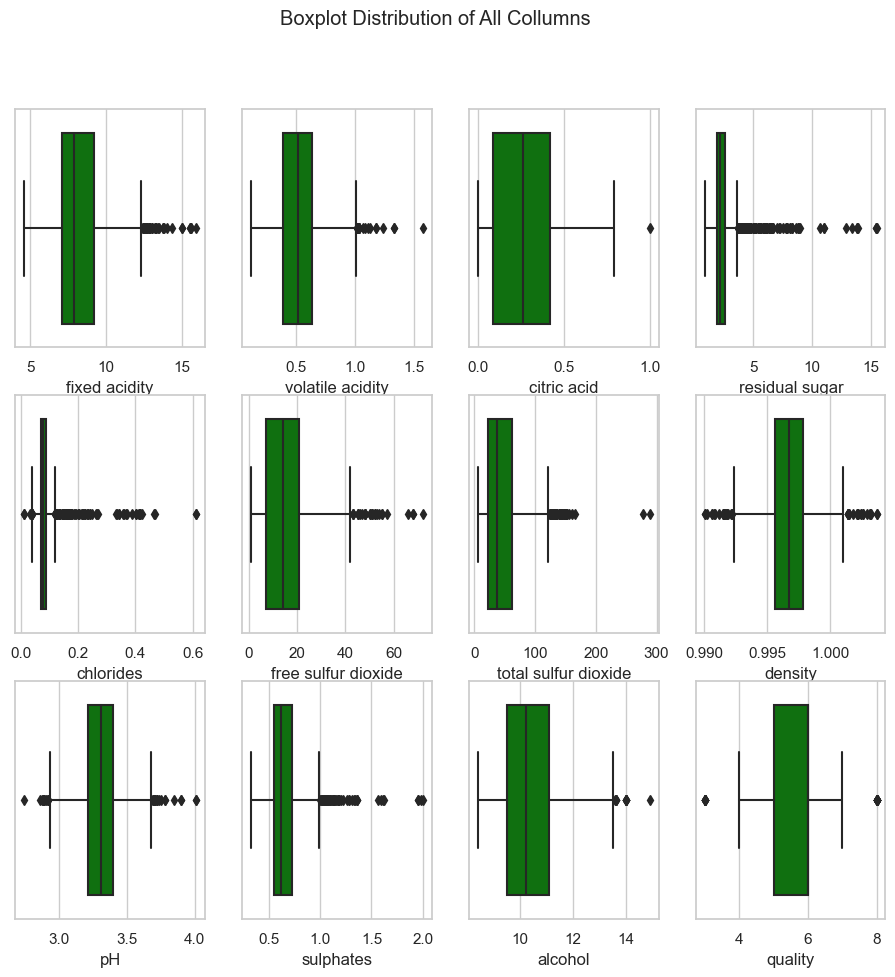

In [179]:
features = data.columns.tolist()
plt.figure(figsize=(10,10))
for i in range(0, len(features)):
  plt.subplot(3, 4, i+1)
  sns.boxplot(x=data[features[i]], color='green', orient='h')
plt.suptitle('Boxplot Distribution of All Collumns')

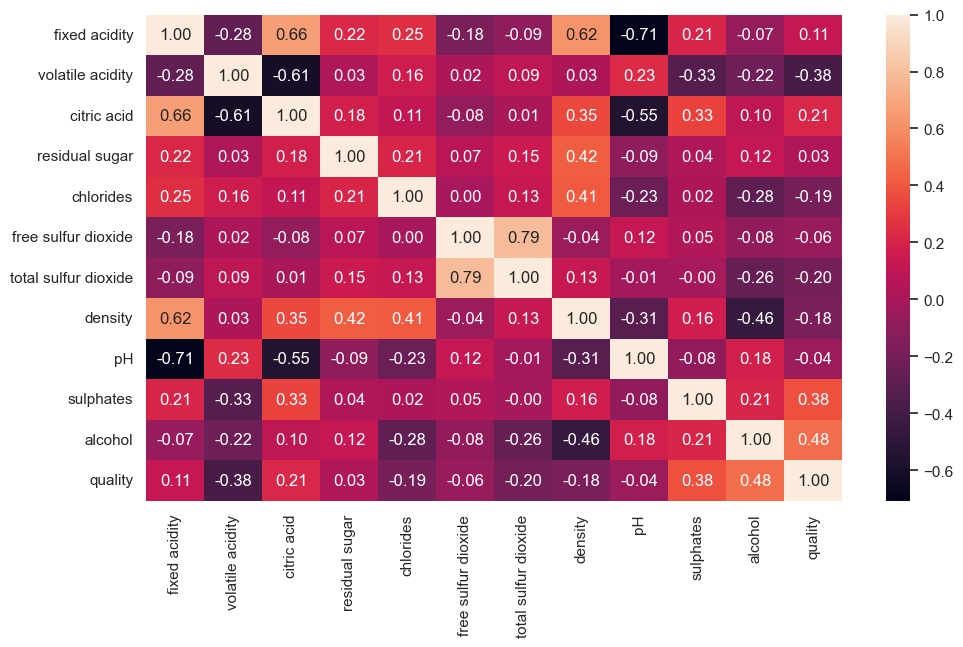

In [180]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(data=data.corr(method='spearman'), annot=True, fmt='.2f')


In [181]:
#drop residual sugar and pH and free sulfur di oxide
data=data.drop(columns=['residual sugar', 'free sulfur dioxide','pH'],axis=1)

## Data Preprocessing

In [182]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
chlorides               0
total sulfur dioxide    0
density                 0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [183]:
data.duplicated().sum()

240

In [184]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [185]:
X = data.drop('quality', axis = 1)
y = data['quality']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=17)

## Feature Creation

In [186]:
#Create new features of total acidity and bound sulfur dioxide
X_train['total acidity'] = X_train['fixed acidity'] + X_train['volatile acidity']
X_test['total acidity'] = X_test['fixed acidity'] + X_test['volatile acidity']

In [187]:
Y_train= Y_train.apply(lambda x: 0 if x <= 5 else 1)
Y_test = Y_test.apply(lambda x: 0 if x <= 5 else 1)
Y_train.value_counts()



# dataset is balance now

1    568
0    519
Name: quality, dtype: int64

In [188]:
iqr_train = X_train.copy()

# Handling outliers using IQR method
for i in iqr_train.columns:
    q1_train = iqr_train[i].quantile(0.25)
    q3_train = iqr_train[i].quantile(0.75)
    iqr_calc_train = q3_train - q1_train
    low_limit_train = q1_train - (1.5 * iqr_calc_train)
    high_limit_train = q3_train + (1.5 * iqr_calc_train)
    iqr_filtered_train = (iqr_train[i] >= low_limit_train) & (iqr_train[i] <= high_limit_train)
    iqr_train = iqr_train[iqr_filtered_train]

print('Before removing outliers:', X_train.shape[0])
print('After treating with IQR:', iqr_train.shape[0])
    
# Update X_train to the filtered data
X_train = iqr_train.copy()
# Ensure the target variable y_train is aligned with the filtered X_train
Y_train = Y_train.loc[iqr_train.index]



Before removing outliers: 1087
After treating with IQR: 888


In [189]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Taining a Model

In [190]:
def evaluation_fn(best_model,X_test_scaled,Y_test):
    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test_scaled)
    print(classification_report(Y_test, y_pred))

    # ROC curve and AUC
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       121
           1       0.74      0.78      0.76       151

    accuracy                           0.73       272
   macro avg       0.73      0.72      0.72       272
weighted avg       0.73      0.73      0.73       272



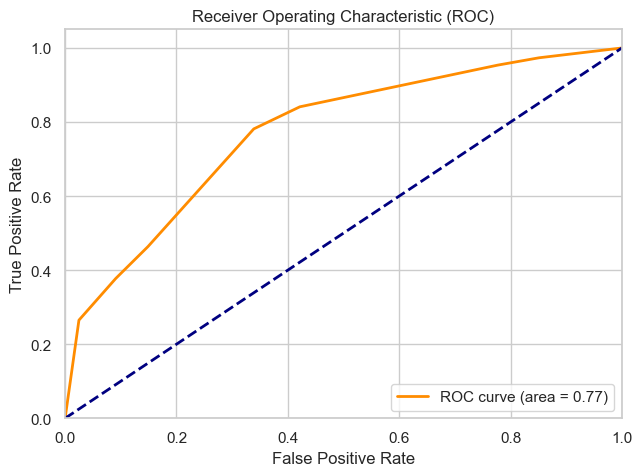

In [191]:
model = DecisionTreeClassifier(random_state=17)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, Y_train)

best_model = grid_search.best_estimator_
evaluation_fn(best_model,X_test_scaled,Y_test)

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       121
           1       0.80      0.80      0.80       151

    accuracy                           0.78       272
   macro avg       0.78      0.78      0.78       272
weighted avg       0.78      0.78      0.78       272



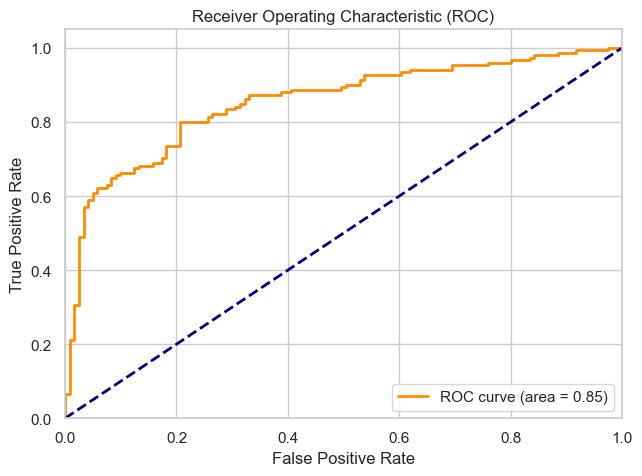

In [192]:
# Random Forest Classifier with hyperparameter tuning
rf_model = RandomForestClassifier(random_state=17)
param_grid_rf = {
    'n_estimators': [60,100, 120, 150],
    'max_depth': [3, 5, 7,],
    'min_samples_split': [2, 5, 10],
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train_scaled, Y_train)
best_rf_model = grid_search_rf.best_estimator_
print("Random Forest Classifier:")
evaluation_fn(best_rf_model, X_test_scaled, Y_test)

In [193]:
# Built-in feature importance (Gini Importance)
importances = best_rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                Feature  Gini Importance
7               alcohol         0.278574
6             sulphates         0.150459
1      volatile acidity         0.124664
4  total sulfur dioxide         0.101794
5               density         0.091668
8         total acidity         0.070087
3             chlorides         0.069202
2           citric acid         0.060020
0         fixed acidity         0.053533


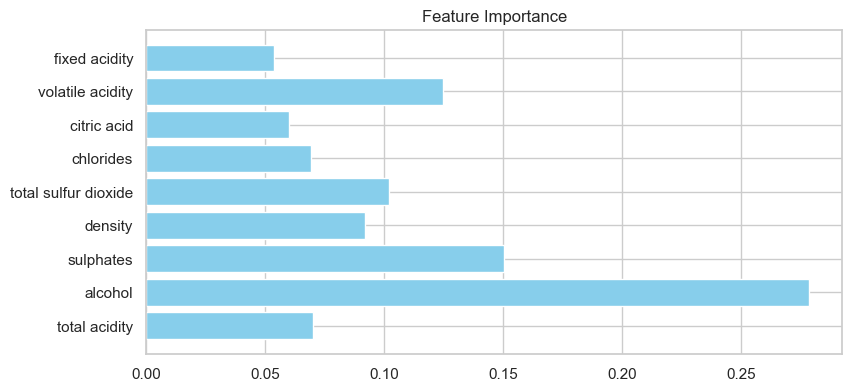

In [194]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(X_train.columns, importances, color='skyblue')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

In [195]:
# the most imnportaant features for best quality wine are alcohol and prenscene of sulphate